# Analysis of Bayesian Imputation on Real Data

In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import arviz as az
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load raw data

In [111]:
input_data = pd.read_csv(r"../model_code/data/Choi2017_model_input.csv")
sample_proteins = ['P47133', 'P40078', 'Q03327', 'P38803', 'P38255', 'Q12402',
                       'P40302', 'P36120', 'P36141', 'P07283', 'P38127', 'P40094',
                       'P35724', 'Q01852', 'Q02159', 'Q01662', 'P38758', 'P38889',
                       'P40024', 'P53741', 'P40040', 'P50087', 'P25617', 'P54839',
                       'P53301', 'P38332', 'P31383', 'P08964', 'P53163', 'Q04693',
                       'P40015', 'Q02455', 'P38882', 'P36154', 'P20606', 'Q12198',
                       'Q06142', 'P50101', 'P40989', 'Q06682', 'P32465', 'P47031',
                       'P38708', 'P34232', 'P39743', 'P35179', 'Q02256', 'Q06708']
input_data = input_data.loc[input_data["Protein"].isin(sample_proteins)]
input_data.head()

Protein   Condition                    Run              Feature  \
120  Q02256  Condition1  JD_06232014_sample1-A  (ac)AGNANSVDEEVTR_2   
121  Q02256  Condition1  JD_06232014_sample1_B  (ac)AGNANSVDEEVTR_2   
122  Q02256  Condition1  JD_06232014_sample1_C  (ac)AGNANSVDEEVTR_2   
123  Q02256  Condition2  JD_06232014_sample2_A  (ac)AGNANSVDEEVTR_2   
124  Q02256  Condition2  JD_06232014_sample2_B  (ac)AGNANSVDEEVTR_2   

     Intensity  Missing  
120        NaN        1  
121        NaN        1  
122  23.157584        0  
123        NaN        1  
124  23.635334        0

## Analyze where we can impute

Calculate total missing for each protein

In [112]:
input_data.groupby("Protein")["Missing"].sum() / input_data.groupby("Protein")["Missing"].count()

Protein
P07283    0.013333
P08964    0.268519
P20606    0.060606
P25617    0.190476
P31383    0.143939
P32465    0.194444
P34232    0.200000
P35179    0.083333
P35724    0.316667
P36120    0.208333
P36141    0.138889
P36154    0.000000
P38127    0.083333
P38255    0.194444
P38332    0.350000
P38708    0.075758
P38758    0.000000
P38803    0.083333
P38882    0.136364
P38889    0.208333
P39743    0.038889
P40015    0.222222
P40024    0.083333
P40040    0.083333
P40078    0.041667
P40094    0.000000
P40302    0.074074
P40989    0.208333
P47031    0.214286
P47133    0.259259
P50087    0.116667
P50101    0.241667
P53163    0.194444
P53301    0.000000
P53741    0.077381
P54839    0.032051
Q01662    0.069444
Q01852    0.109649
Q02159    0.166667
Q02256    0.138889
Q02455    0.141667
Q03327    0.333333
Q04693    0.133333
Q06142    0.100000
Q06682    0.104167
Q06708    0.194444
Q12198    0.150000
Q12402    0.000000
Name: Missing, dtype: float64

Experimental design for each protein

In [113]:
design = input_data.groupby(["Protein"])["Condition", "Run", "Feature"].nunique().reset_index()
design

/tmp/ipykernel_20146/1178144527.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  design = input_data.groupby(["Protein"])["Condition", "Run", "Feature"].nunique().reset_index()


Protein  Condition  Run  Feature
0   P07283          4   12       25
1   P08964          4   12        9
2   P20606          4   12       11
3   P25617          4   12        7
4   P31383          4   12       11
5   P32465          4   12        3
6   P34232          4   12        5
7   P35179          4   12        2
8   P35724          4   12        5
9   P36120          4   12        6
10  P36141          4   12        3
11  P36154          4   12        5
12  P38127          4   12        1
13  P38255          4   12        3
14  P38332          4   12        5
15  P38708          4   12       44
16  P38758          4   12       10
17  P38803          4   12        2
18  P38882          4   12       11
19  P38889          4   12        2
20  P39743          4   12       15
21  P40015          4   12        3
22  P40024          4   12       28
23  P40040          4   12        7
24  P40078          4   12        4
25  P40094          4   12        1
26  P40302          4   12       18
27  P40989          4   12        2
28  P47031          4   12        7
29  P47133          4   12        9
30  P50087          4   12        5
31  P50101          4   12       10
32  P53163          4   12        6
33  P53301          4   12        3
34  P53741          4   12       14
35  P54839          4   12       26
36  Q01662          4   12       18
37  Q01852          4   12       19
38  Q02159          4   12        3
39  Q02256          4   12        9
40  Q02455          4   12       30
41  Q03327          4   12        2
42  Q04693          4   12        5
43  Q06142          4   12       15
44  Q06682          4   12        4
45  Q06708          4   12        6
46  Q12198          4   12        5
47  Q12402          4   12        4

Check how many features are missing in each run

In [114]:
missing_runs = input_data["Intensity"].isnull().groupby([input_data["Protein"], input_data["Run"]]).sum().reset_index()
missing_runs.head()

Protein                    Run  Intensity
0  P07283  JD_06232014_sample1-A          0
1  P07283  JD_06232014_sample1_B          0
2  P07283  JD_06232014_sample1_C          0
3  P07283  JD_06232014_sample2_A          1
4  P07283  JD_06232014_sample2_B          0

Check what runs are totally missing

In [115]:
missing_runs = pd.merge(missing_runs, design, on="Protein", how="left")
missing_runs[missing_runs["Intensity"] == missing_runs["Feature"]]

Protein                  Run_x  Intensity  Condition  Run_y  Feature
152  P38127  JD_06232014_sample3_C          1          4     12        1

Check what features are only measured once

In [116]:
input_data[-np.isnan(input_data["Intensity"])].groupby(["Protein", "Feature"])["Run"].count()[
    input_data[-np.isnan(input_data["Intensity"])].groupby(["Protein", "Feature"])["Run"].count() == 1]

Series([], Name: Run, dtype: int64)

For these proteins, we should be able to impute all runs and all features.

/tmp/ipykernel_20146/3620740094.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


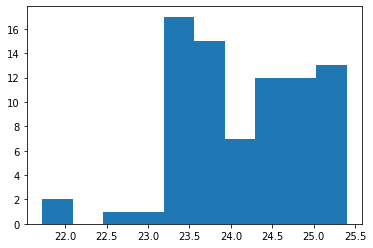

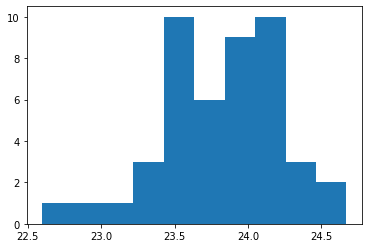

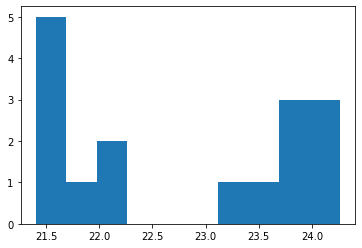

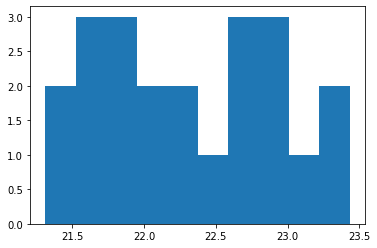

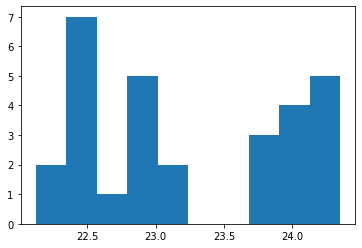

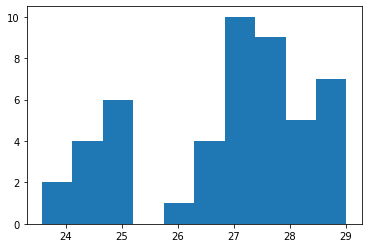

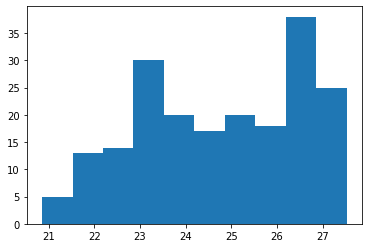

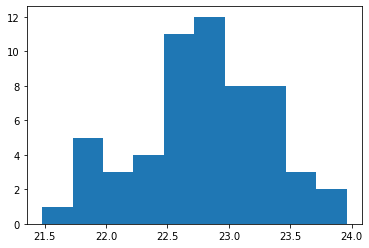

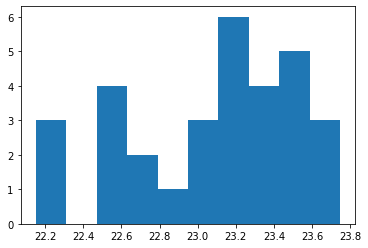

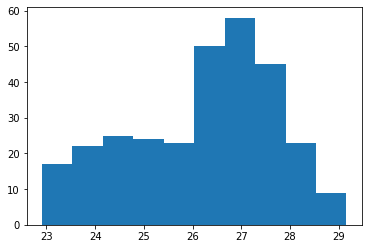

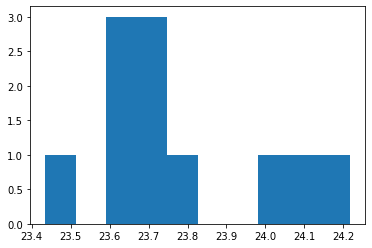

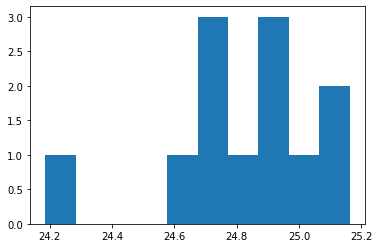

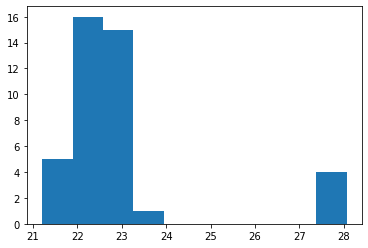

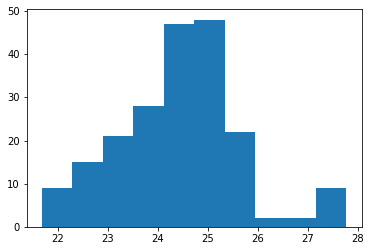

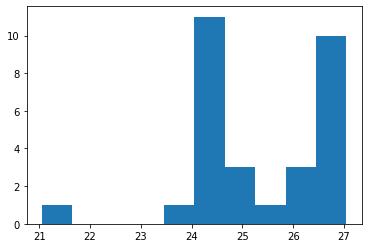

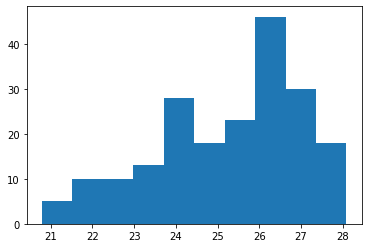

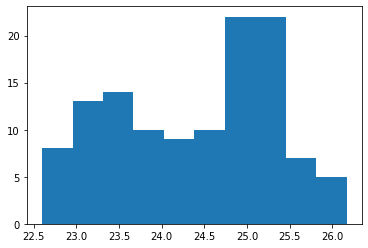

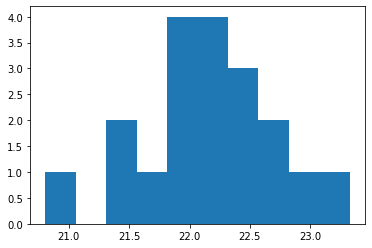

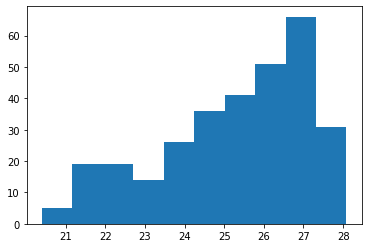

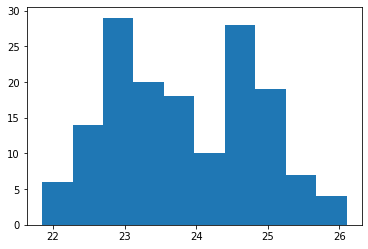

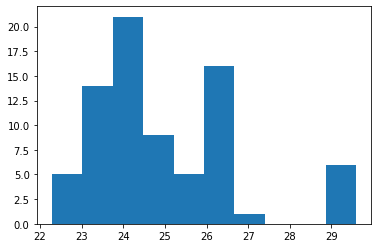

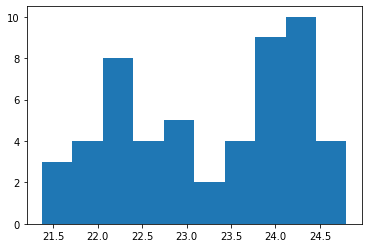

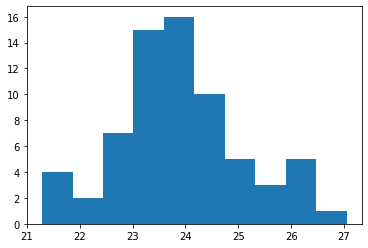

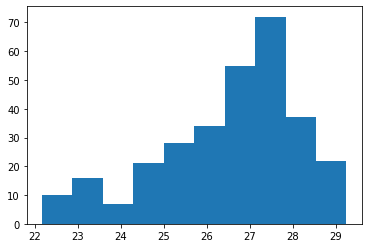

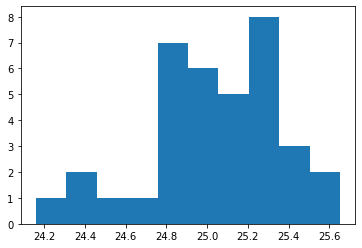

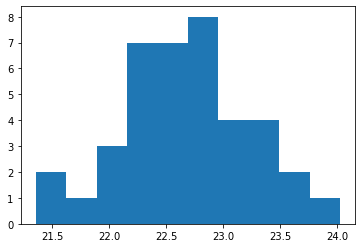

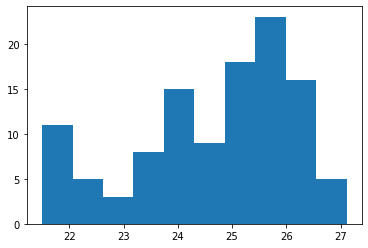

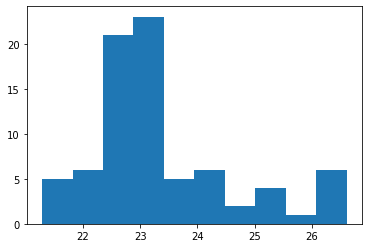

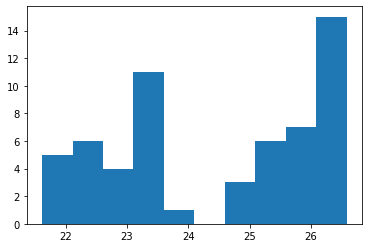

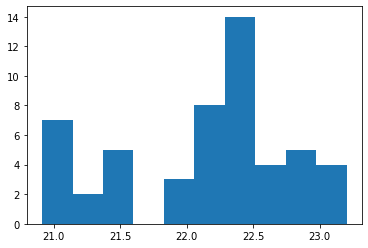

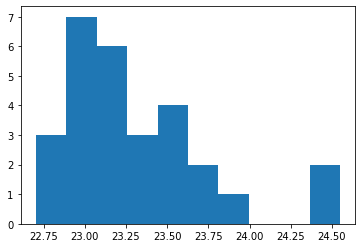

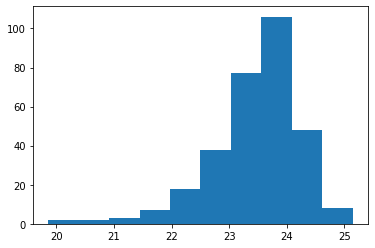

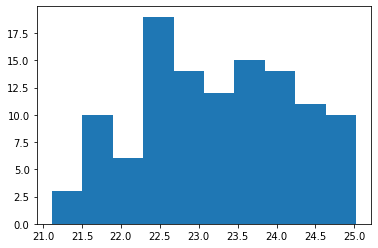

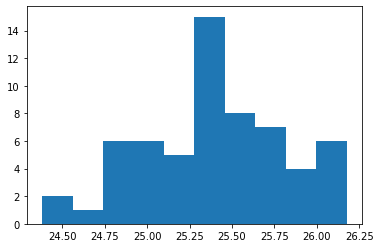

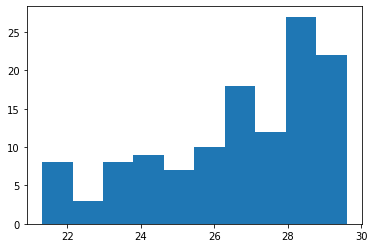

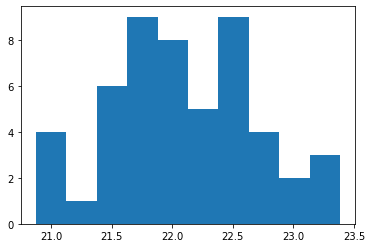

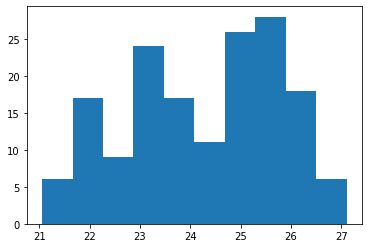

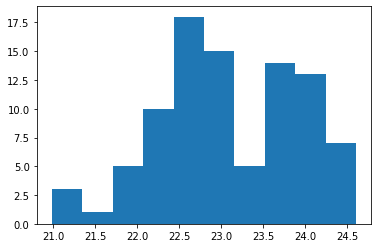

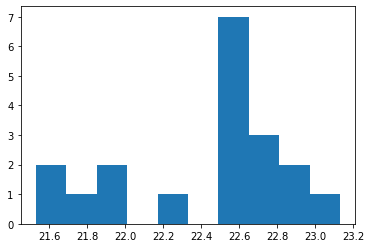

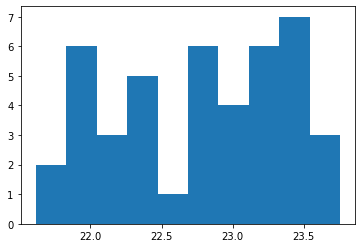

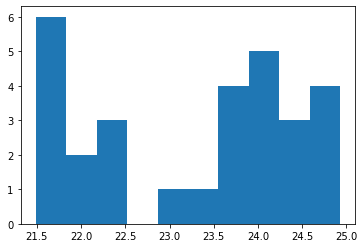

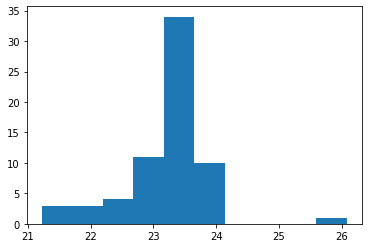

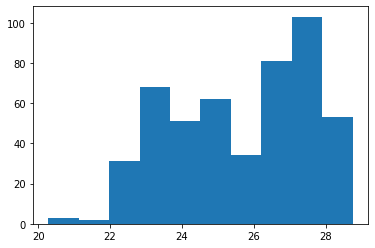

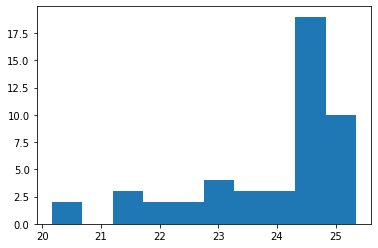

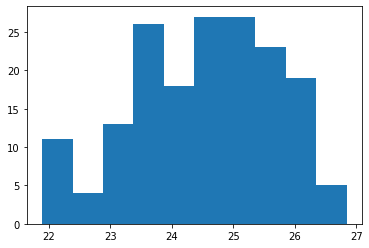

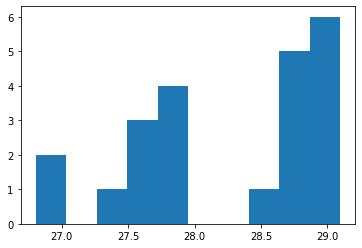

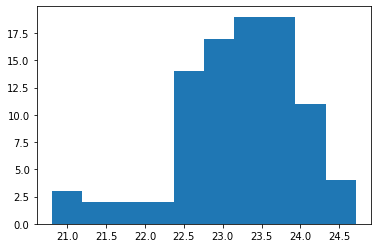

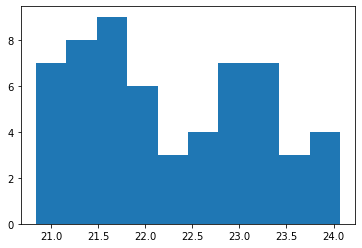

In [117]:
for i in sample_proteins:
    fig, ax = plt.subplots()
    ax.hist(input_data[input_data["Protein"] == i]["Intensity"])

/tmp/ipykernel_20146/2631368975.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile.loc[:, "Run_feature"] = profile.loc[:, "Run"].astype(str) + "_" + profile.loc[:, "Feature"].astype(str)
/tmp/ipykernel_20146/2631368975.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile.loc[:, "Feature"] = profile.loc[:, "Feature"].astype(str)
/tmp/ipykernel_20146/2631368975.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

Text(0.5, 0, 'Run')

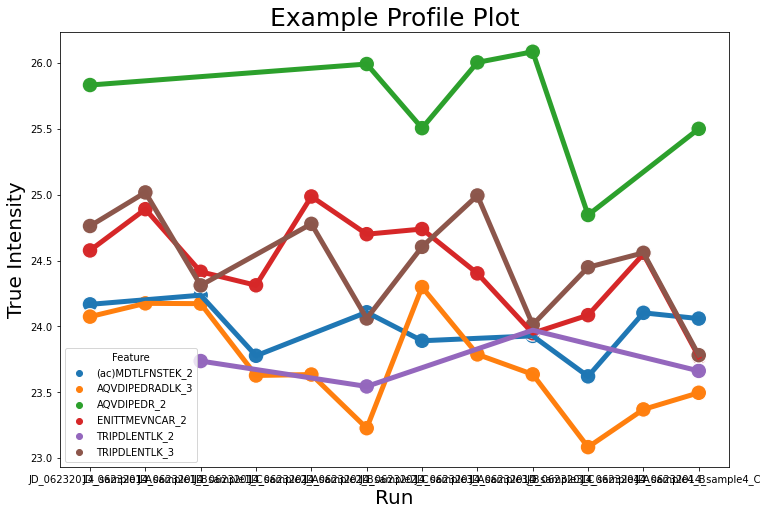

In [56]:
profile = input_data[input_data["Protein"] == "P48363"]
profile.loc[:, "Run_feature"] = profile.loc[:, "Run"].astype(str) + "_" + profile.loc[:, "Feature"].astype(str)
profile.loc[:, "Feature"] = profile.loc[:, "Feature"].astype(str)
profile.loc[:, "Run"] = profile.loc[:, "Run"].astype(str)

fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(data=profile, x="Run", y="Intensity", hue="Feature",ax=ax,lw=5, legend=False)
sns.scatterplot(data=profile, x="Run", y="Intensity", hue="Feature",ax=ax, s=250, alpha=.99)

ax.set_title("Example Profile Plot",fontdict={'fontsize': 25})
ax.set_ylabel("True Intensity",fontdict={'fontsize': 20})
ax.set_xlabel("Run",fontdict={'fontsize': 20})

/tmp/ipykernel_20146/4016879108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile.loc[:, "Run_feature"] = profile.loc[:, "Run"].astype(str) + "_" + profile.loc[:, "Feature"].astype(str)
/tmp/ipykernel_20146/4016879108.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile.loc[:, "Feature"] = profile.loc[:, "Feature"].astype(str)
/tmp/ipykernel_20146/4016879108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

Text(0.5, 0, 'Run')

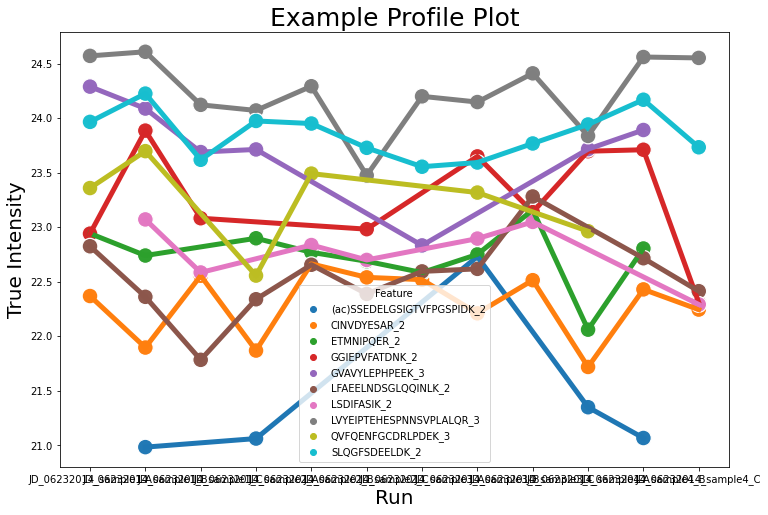

In [118]:
profile = input_data[input_data["Protein"] == "P50101"]
profile.loc[:, "Run_feature"] = profile.loc[:, "Run"].astype(str) + "_" + profile.loc[:, "Feature"].astype(str)
profile.loc[:, "Feature"] = profile.loc[:, "Feature"].astype(str)
profile.loc[:, "Run"] = profile.loc[:, "Run"].astype(str)

fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(data=profile, x="Run", y="Intensity", hue="Feature",ax=ax,lw=5, legend=False)
sns.scatterplot(data=profile, x="Run", y="Intensity", hue="Feature",ax=ax, s=250, alpha=.99)

ax.set_title("Example Profile Plot",fontdict={'fontsize': 25})
ax.set_ylabel("True Intensity",fontdict={'fontsize': 20})
ax.set_xlabel("Run",fontdict={'fontsize': 20})

## MCMC model

In [98]:
with open(r"../model_code/data/real_data_20_proteins.pickle", "rb") as input_file:
    mcmc = pickle.load(input_file)
with open(r"../model_code/data/real_data_1_proteins.pickle", "rb") as input_file:
    mcmc_one = pickle.load(input_file)
n=20

In [95]:
mcmc

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'mar'}>,
        <AxesSubplot:title={'center':'mar'}>]], dtype=object)

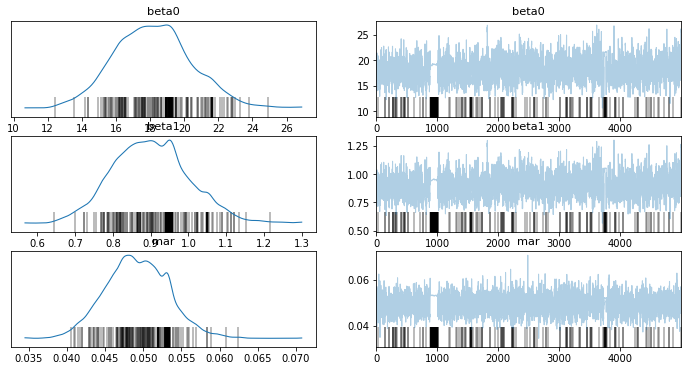

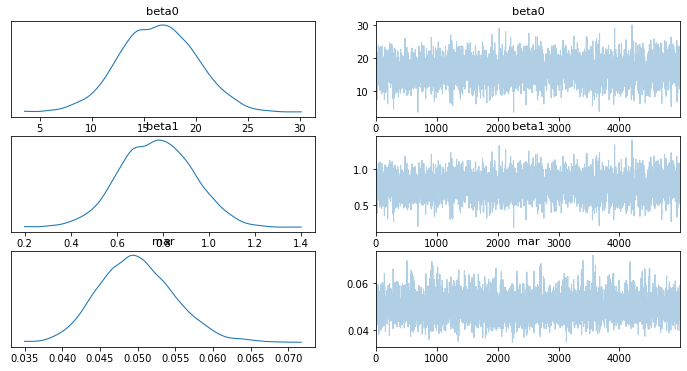

In [99]:
az.plot_trace(mcmc, var_names=["beta0", "beta1", "mar"])
az.plot_trace(mcmc_one, var_names=["beta0", "beta1", "mar"])

array([[<AxesSubplot:title={'center':'mu_0'}>,
        <AxesSubplot:title={'center':'mu_0'}>]], dtype=object)

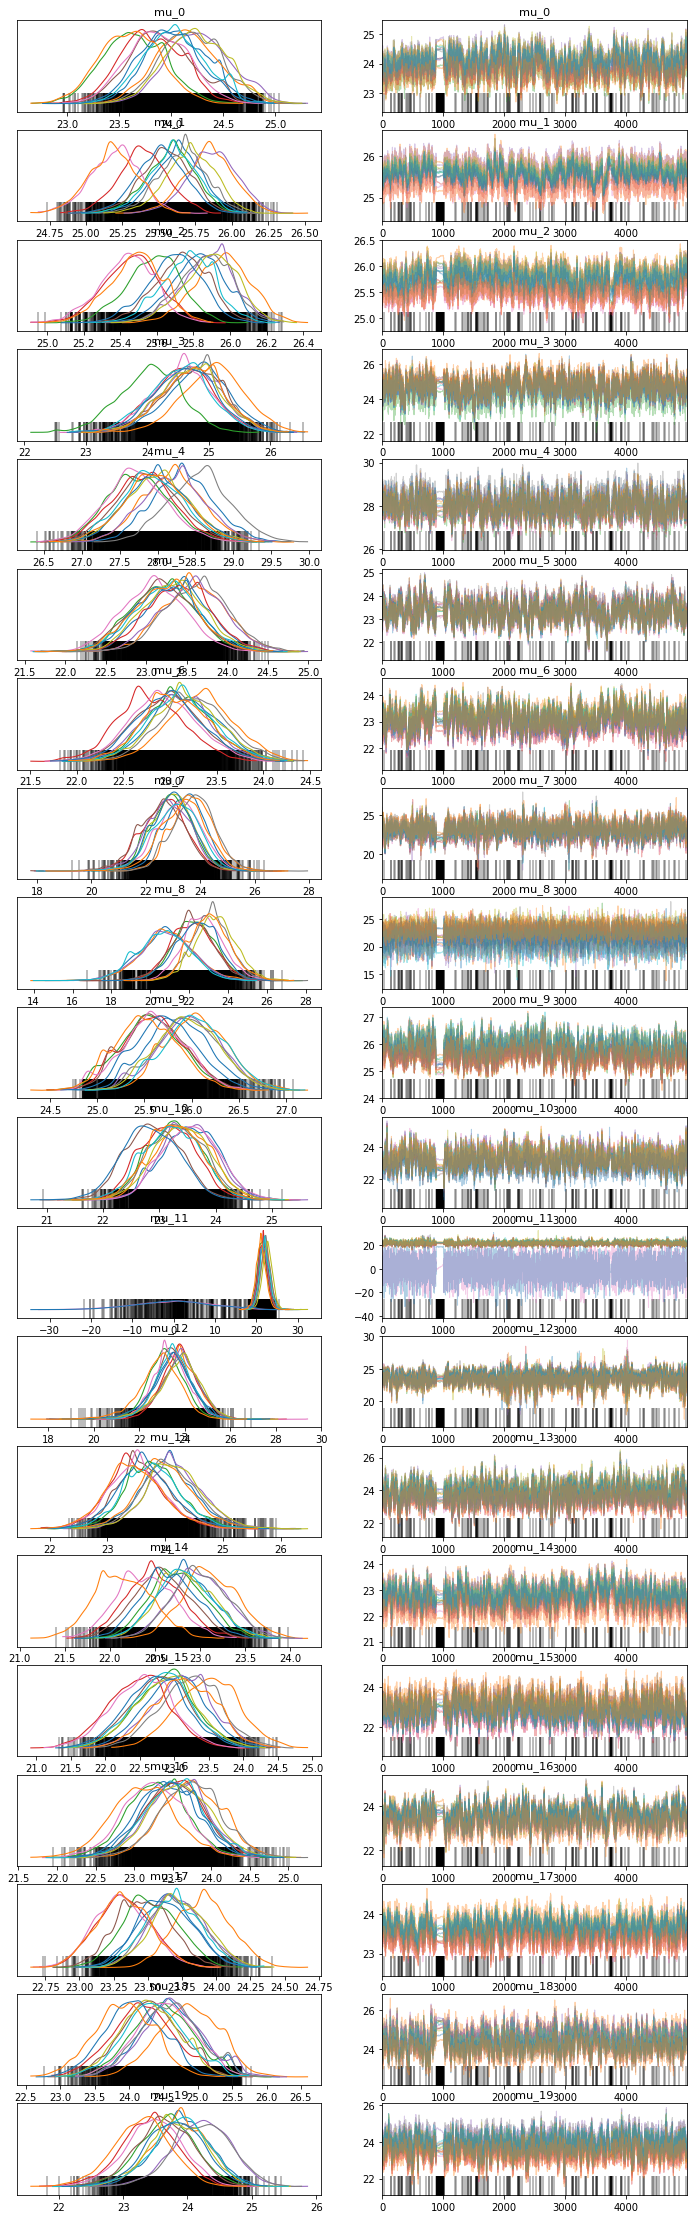

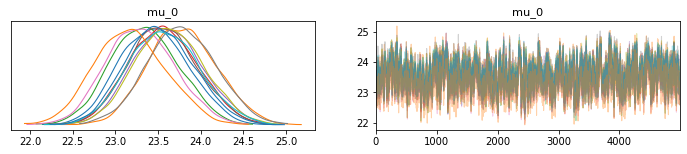

In [100]:
az.plot_trace(mcmc, var_names=["mu_{}".format(i) for i in range(n)])
az.plot_trace(mcmc_one, var_names=["mu_{}".format(i) for i in range(1)])

IndexError: index 0 is out of bounds for axis 0 with size 0

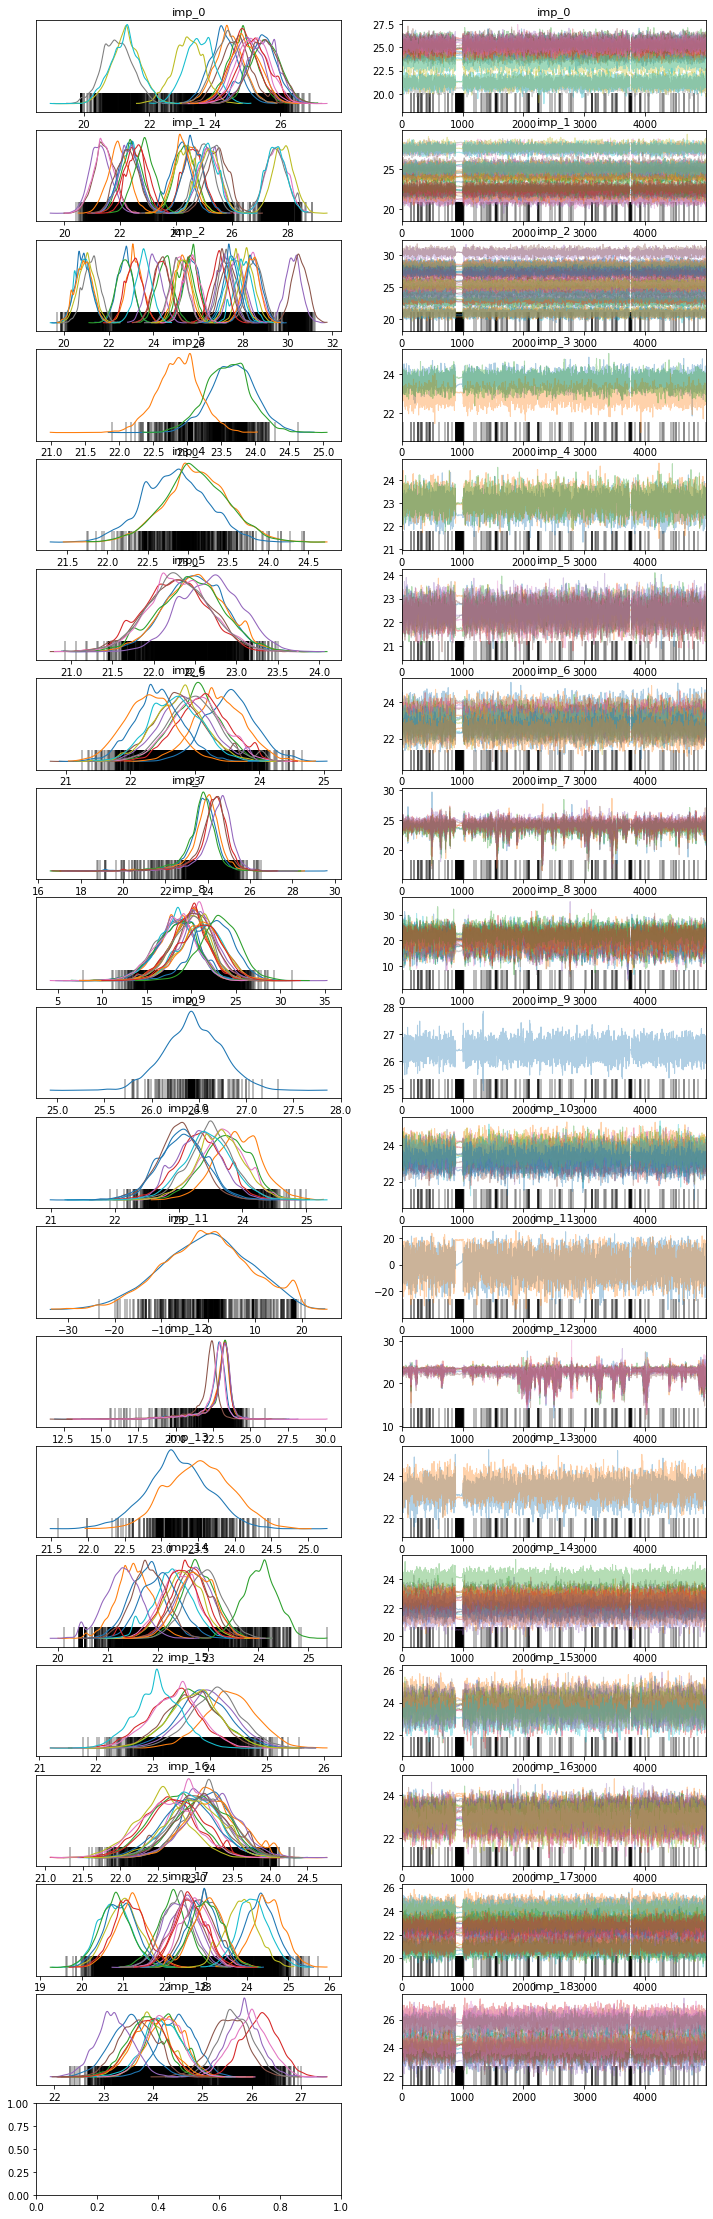

In [101]:
az.plot_trace(mcmc, var_names=["imp_{}".format(i) for i in range(n)])
az.plot_trace(mcmc_one, var_names=["imp_{}".format(i) for i in range(1)])

array([[<AxesSubplot:title={'center':'bF_0'}>,
        <AxesSubplot:title={'center':'bF_0'}>]], dtype=object)

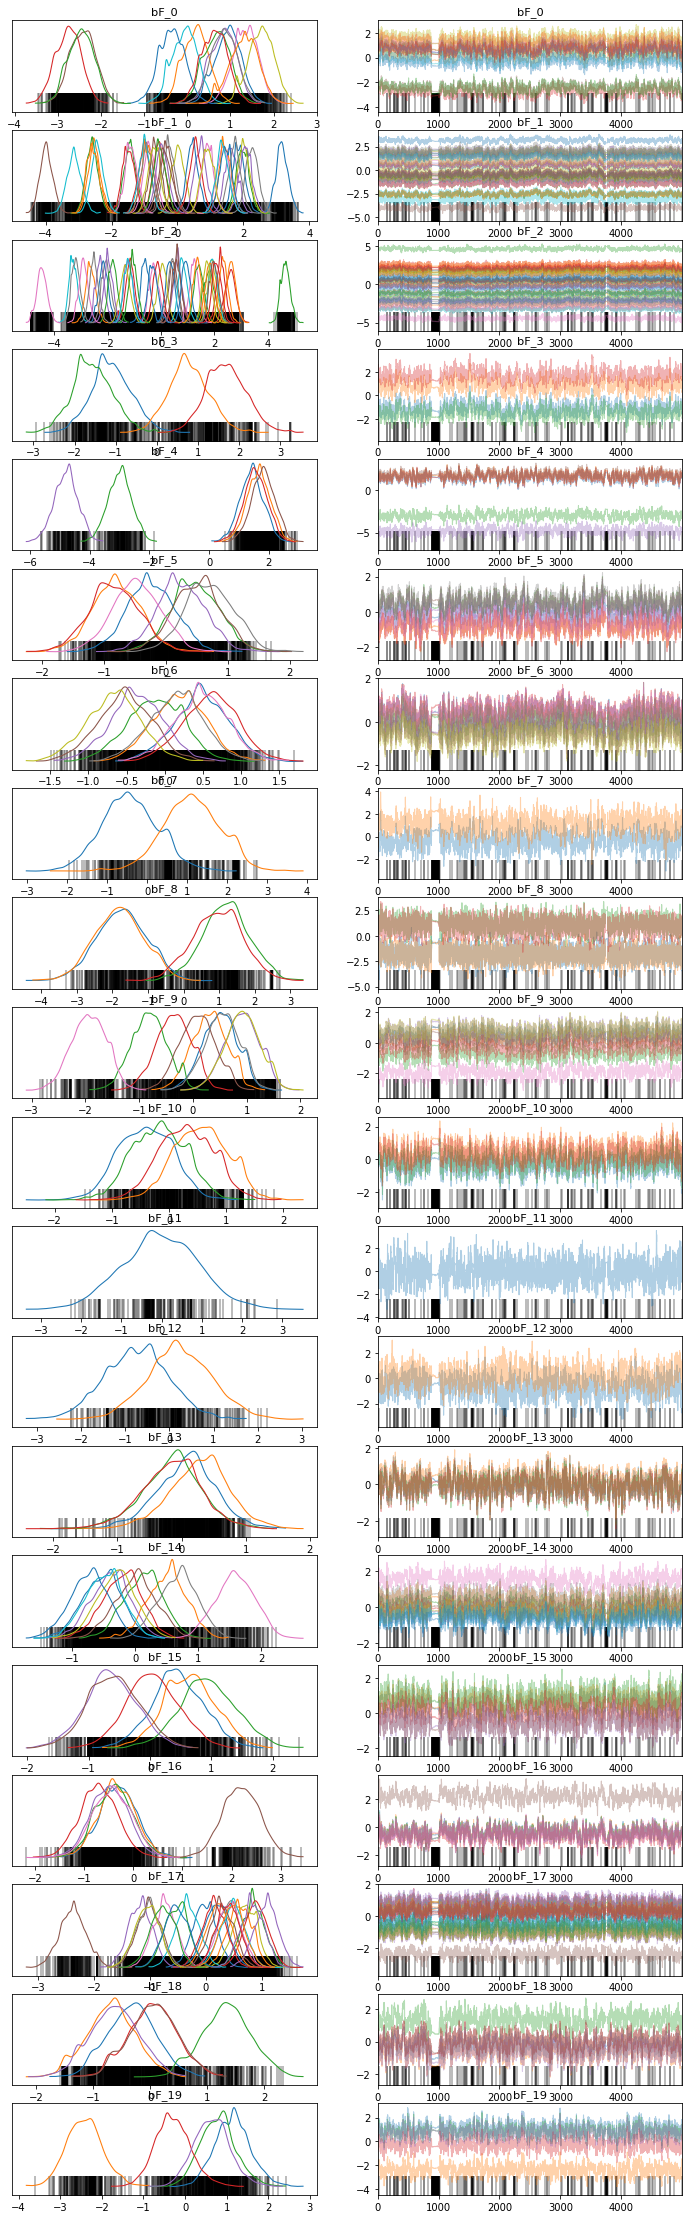

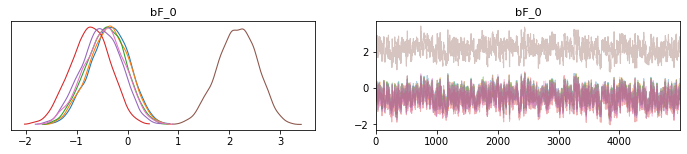

In [102]:
az.plot_trace(mcmc, var_names=["bF_{}".format(i) for i in range(n)])
az.plot_trace(mcmc_one, var_names=["bF_{}".format(i) for i in range(1)])